# SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers

TL;DR

SegFormer is a semantic segmentation framework that combines Transformers with lightweight MLP decoders. It has a hierarchically structured Transformer encoder that outputs multiscale features without requiring positional encoding. The proposed MLP decoder aggregates information from different layers to render powerful representations, combining both local and global attention. SegFormer's simple and lightweight design is key to its efficient segmentation on Transformers.

- [Paper] : https://arxiv.org/pdf/2105.15203.pdf

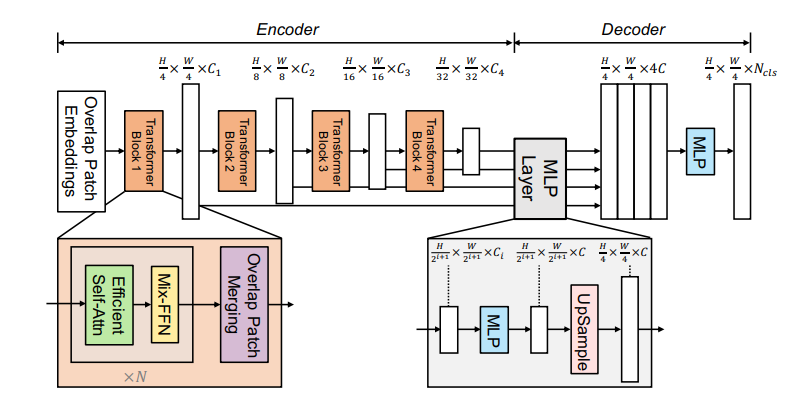

We use mmsegmentation in order to perform zero-shot learning on our data.

In [1]:
from glob import glob

from mmseg.apis import inference_segmentor, init_segmentor
import mmcv
import matplotlib.pyplot as plt
import numpy as np
import cv2

/home/said/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
checkpoint_file = '/home/said/courses/Projetinfo/sports_scr/checkpoints/segformer_mit-b0_512x512_160k_ade20k_20220617_162207-c00b9603.pth'
config_file = '/home/said/courses/Projetinfo/sports_scr/configs/segformer_mit-b0_512x512_160k_ade20k.py'

# build the model from a config file and a checkpoint file
model = init_segmentor(config_file, checkpoint_file, device='cpu')

all_image_paths = glob('/home/said/courses/Projetinfo/sports_scr/data/natation/*.png')

load checkpoint from local path: /home/said/courses/Projetinfo/sports_scr/checkpoints/segformer_mit-b0_512x512_160k_ade20k_20220617_162207-c00b9603.pth


/home/said/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


In [3]:
from collections import Counter

In [4]:
def get_roi_segformer(model, img, crop_percent=0.05):
    # Load the image and obtain the segmentation result
    image = cv2.imread(img)
    result = inference_segmentor(model, img)

    # Define class and palette for better visualization
    classes = model.CLASSES
    palette = model.PALETTE

    # Obtain the segmentation mask and set pixels corresponding to regions of interest
    seg = result[0]
    binary_image = np.zeros((seg.shape[0], seg.shape[1]), dtype=np.uint8)
    classes_roi = {43}  # signboard
    #classes_roi = set(map(lambda x: x[0], Counter(seg.flatten()).most_common(5))) - {0}
    print(classes_roi)
    # Plot the classes_roi with their corresponding palette color
    if len(classes_roi) == 1:
        for i, label in enumerate(classes_roi):
            class_name = classes[label]
            class_color = np.array(palette[label])/255.
            plt.imshow((seg == label).astype(np.uint8))
            plt.title(f'{class_name} ({label})', fontsize=12)
    else:
        fig, ax = plt.subplots(1, len(classes_roi), figsize=(10, 10))
        for i, label in enumerate(classes_roi):
            class_name = classes[label]
            class_color = np.array(palette[label])/255.
            ax[i].imshow((seg == label).astype(np.uint8))
            ax[i].set_title(f'{class_name} ({label})', fontsize=12)
            ax[i].set_axis_off()
            ax[i].set_facecolor(class_color)

    for label in classes_roi:
        binary_image[seg == label] = 1

    # Find connected components and obtain the biggest component (excluding background)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image)
    max_label = 1
    max_size = stats[1, cv2.CC_STAT_AREA]
    for i in range(2, num_labels):
        if stats[i, cv2.CC_STAT_AREA] > max_size:
            max_label = i
            max_size = stats[i, cv2.CC_STAT_AREA]

    # Create mask for biggest component and obtain its bounding box
    mask = (labels == max_label).astype(np.uint8)
    x, y, w, h = cv2.boundingRect(mask)

    # Crop the image to the bounding box and calculate the size reduction
    crop_width = int(image.shape[1] * crop_percent)
    crop_height = int(image.shape[0] * crop_percent)

    x += crop_width
    y += crop_height
    w -= 2 * crop_width
    h -= 2 * crop_height

    crop_img = image[y:y+h, x:x+w]

    size_reduction = 100 * w * h / np.prod(image.shape[0:2])
    print(f"Label with max area : {classes[max_label]} --- label : {max_label}")
    print(f"Size reduction new/original: {size_reduction:.2f}%")

    # Plot the original image, binary image, mask, and ROI image side by side
    fig, ax = plt.subplots(1, 4, figsize=(10, 10))
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[1].imshow(binary_image, cmap='gnuplot')
    ax[1].set_title('Binary Image')
    ax[2].imshow(mask, cmap='gnuplot')
    ax[2].set_title('Mask')
    ax[3].imshow(crop_img, cmap='gnuplot')
    ax[3].set_title('ROI Image')
    plt.show()

    # Return the original image, binary image, mask, and ROI image
    return image, binary_image, mask, crop_img

{43}
Label with max area : building --- label : 1
Size reduction new/original: 33.45%


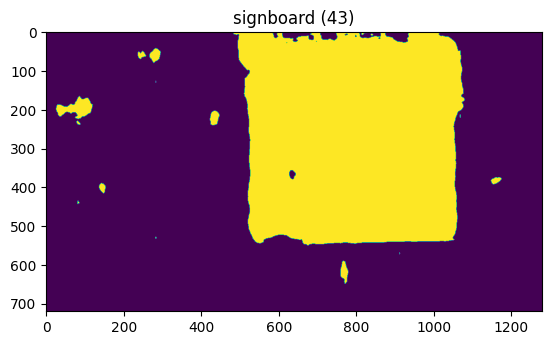

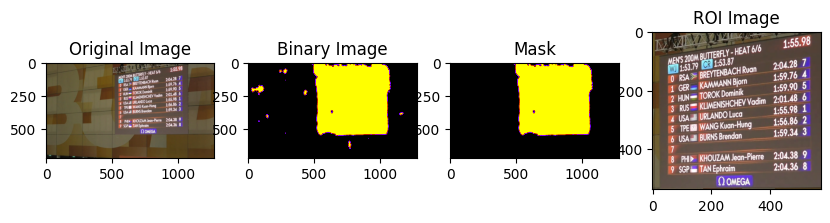

In [5]:
image, binary_image, mask, crop_img = get_roi_segformer(model, all_image_paths[14], crop_percent=0.01)

In [6]:
!mkdir ../data/natation/ROI/

{43}
Label with max area : sky --- label : 2
Size reduction new/original: 77.14%


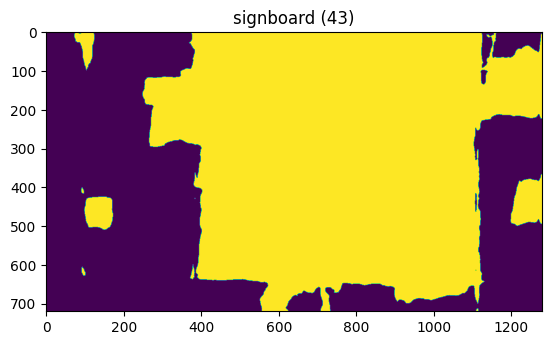

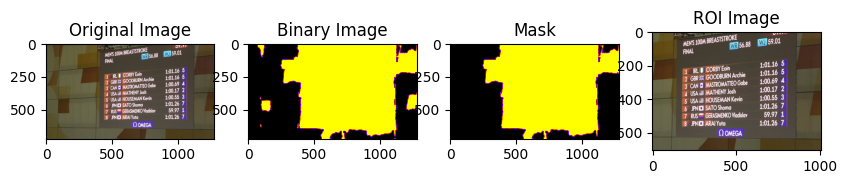

{43}
Label with max area : tree --- label : 4
Size reduction new/original: 69.50%


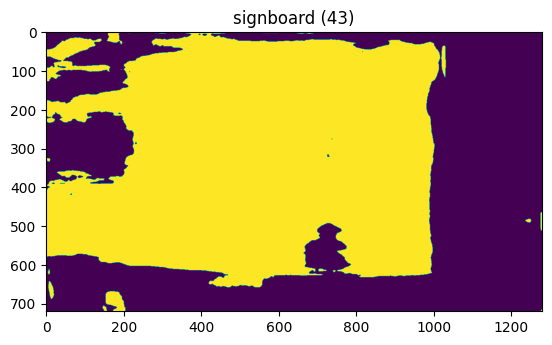

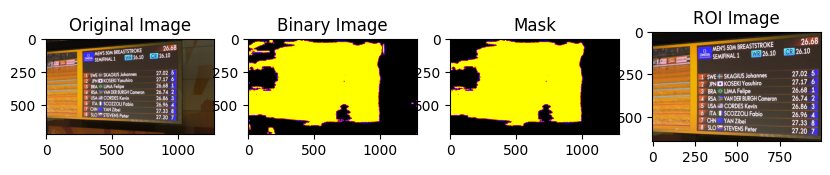

{43}
Label with max area : building --- label : 1
Size reduction new/original: 55.63%


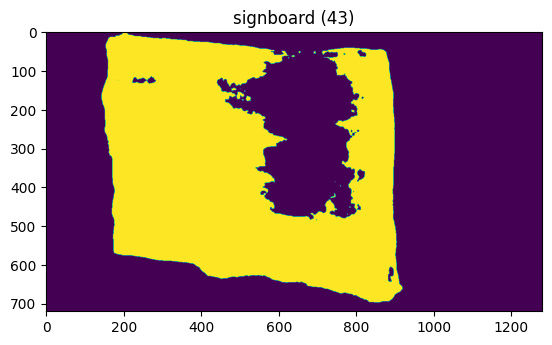

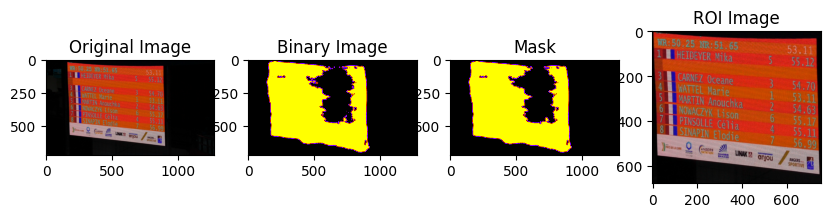

{43}
Label with max area : building --- label : 1
Size reduction new/original: 52.31%


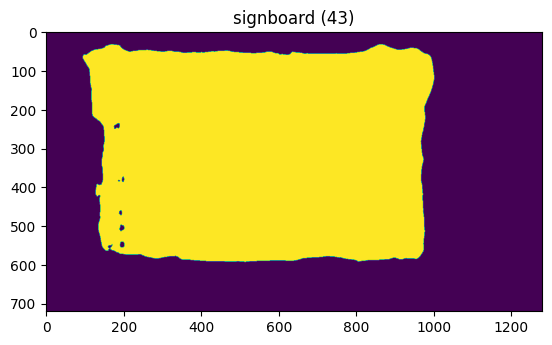

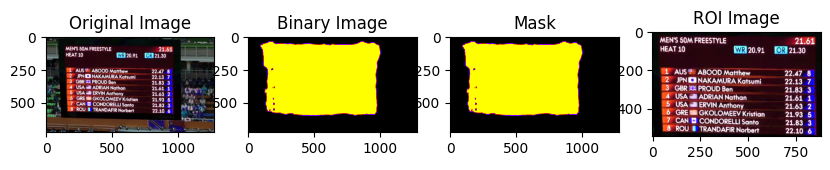

{43}
Label with max area : cabinet --- label : 10
Size reduction new/original: 16.98%


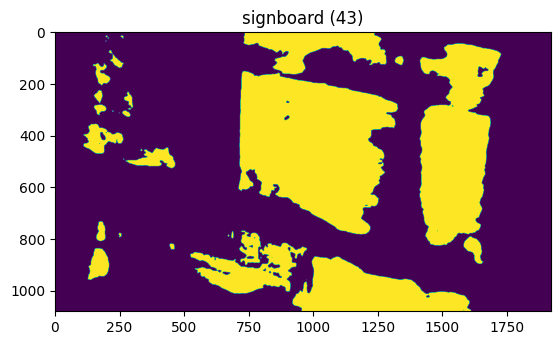

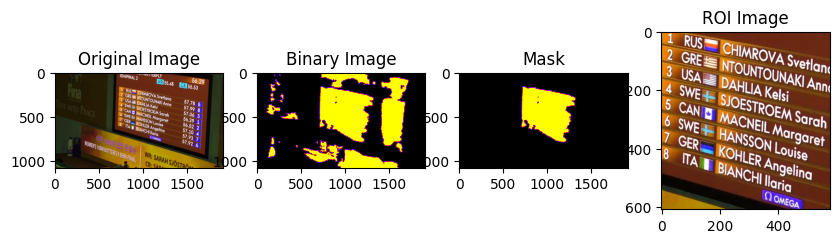

{43}
Label with max area : building --- label : 1
Size reduction new/original: 45.29%


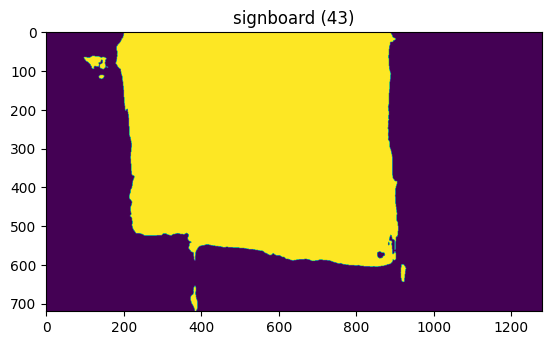

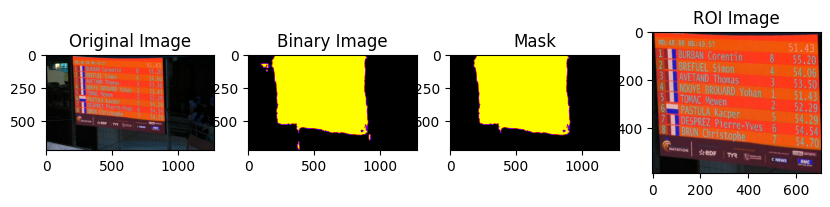

{43}
Label with max area : floor --- label : 3
Size reduction new/original: 27.83%


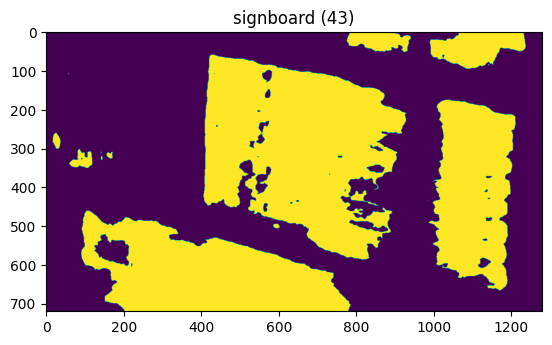

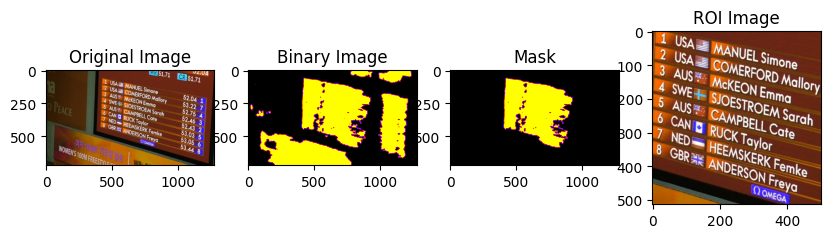

{43}
Label with max area : building --- label : 1
Size reduction new/original: 31.59%


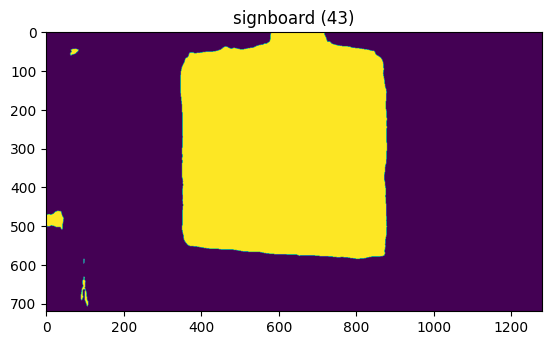

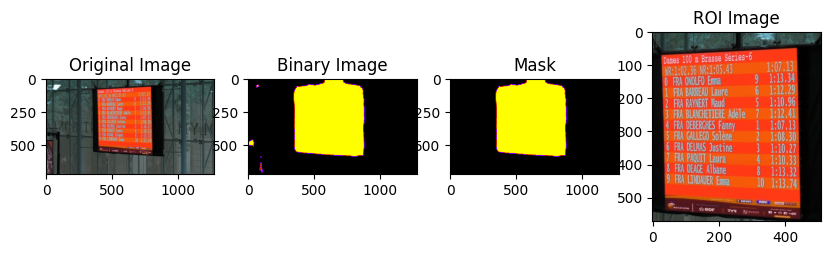

{43}
Label with max area : sky --- label : 2
Size reduction new/original: 53.33%


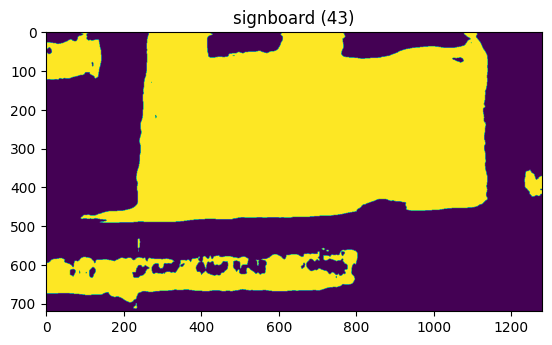

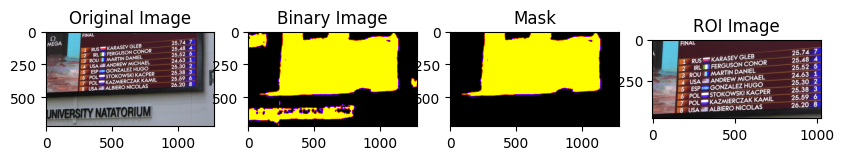

{43}
Label with max area : building --- label : 1
Size reduction new/original: 33.86%


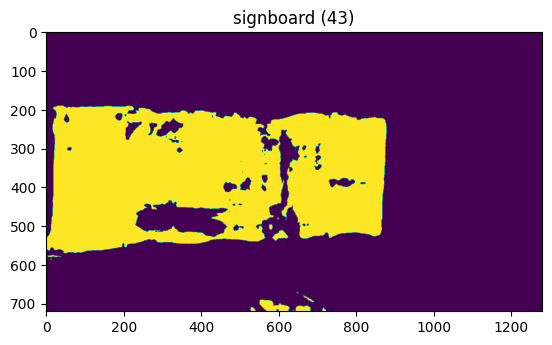

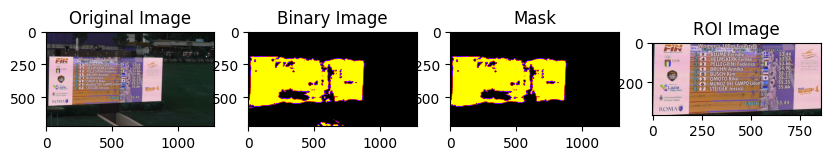

{43}
Label with max area : ceiling --- label : 5
Size reduction new/original: 39.81%


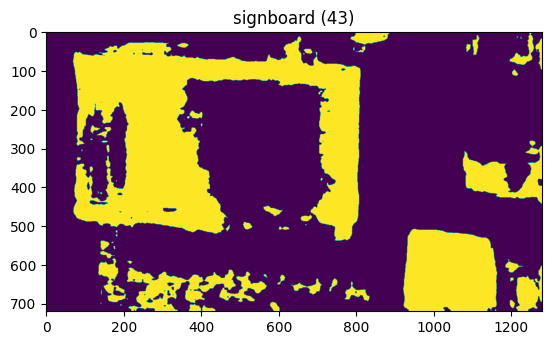

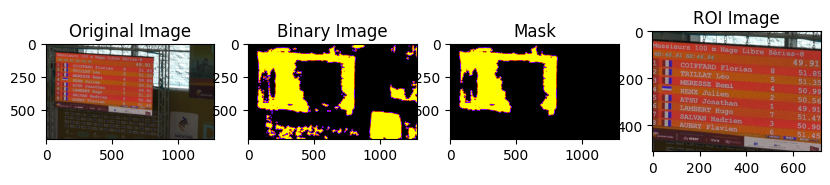

{43}
Label with max area : building --- label : 1
Size reduction new/original: 42.14%


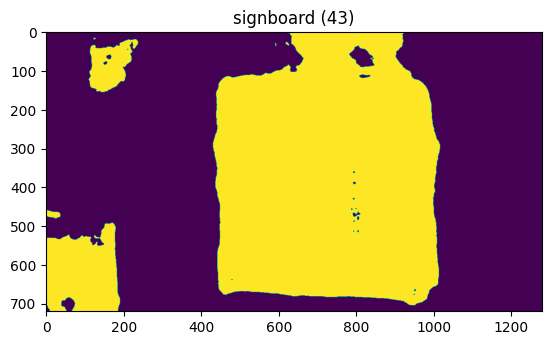

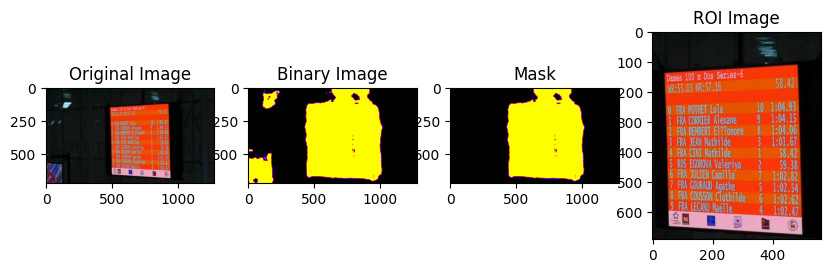

{43}
Label with max area : road --- label : 6
Size reduction new/original: 46.53%


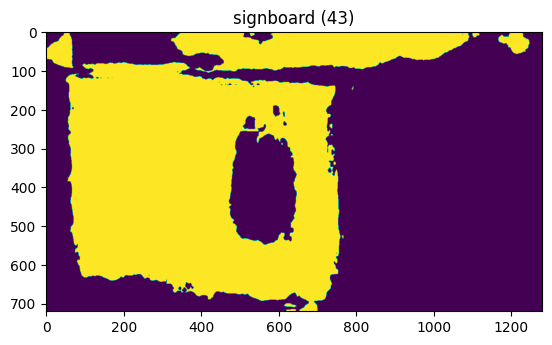

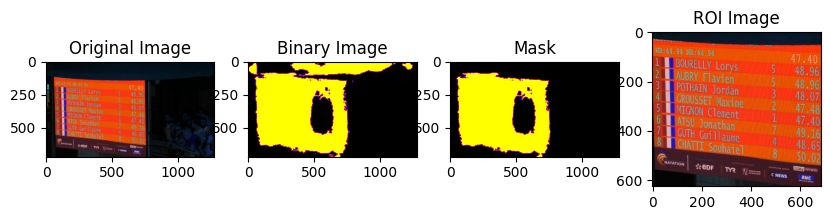

{43}
Label with max area : sky --- label : 2
Size reduction new/original: 53.93%


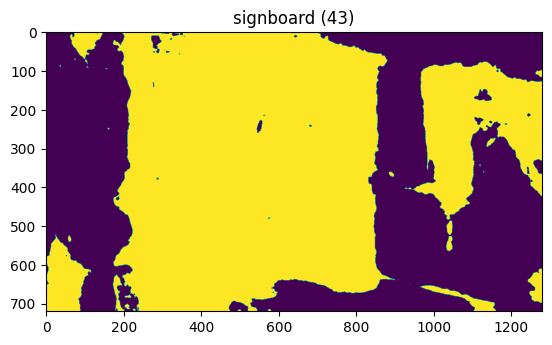

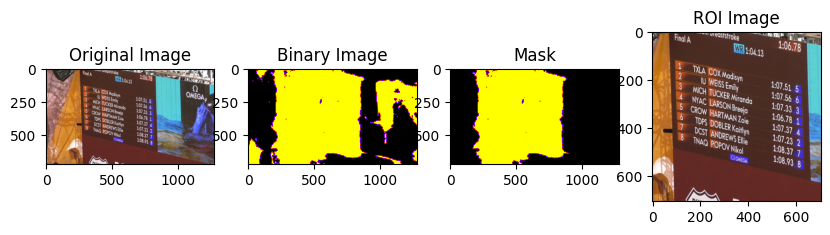

{43}
Label with max area : building --- label : 1
Size reduction new/original: 33.45%


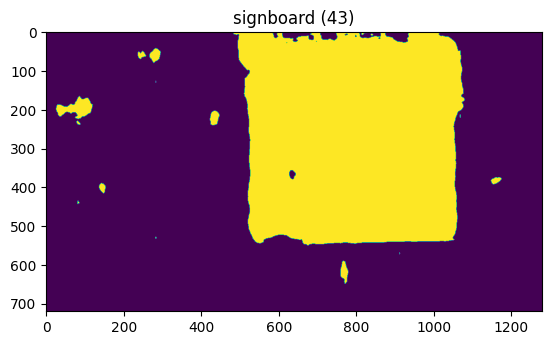

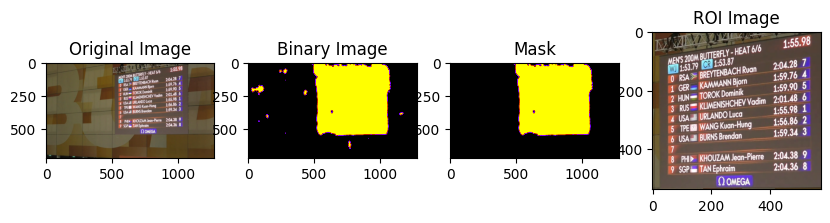

In [7]:
for img in all_image_paths:
    image, binary_image, mask, crop_img = get_roi_segformer(model, img, crop_percent=0.01)

    # Save the image to disk
    cv2.imwrite("../data/natation/ROI/" + img.split("/")[-1], crop_img)

# Other models : PSPNET, Pyramid Scene Parsing Network, 

load checkpoint from local path: /home/said/courses/Projetinfo/sports_scr/checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth


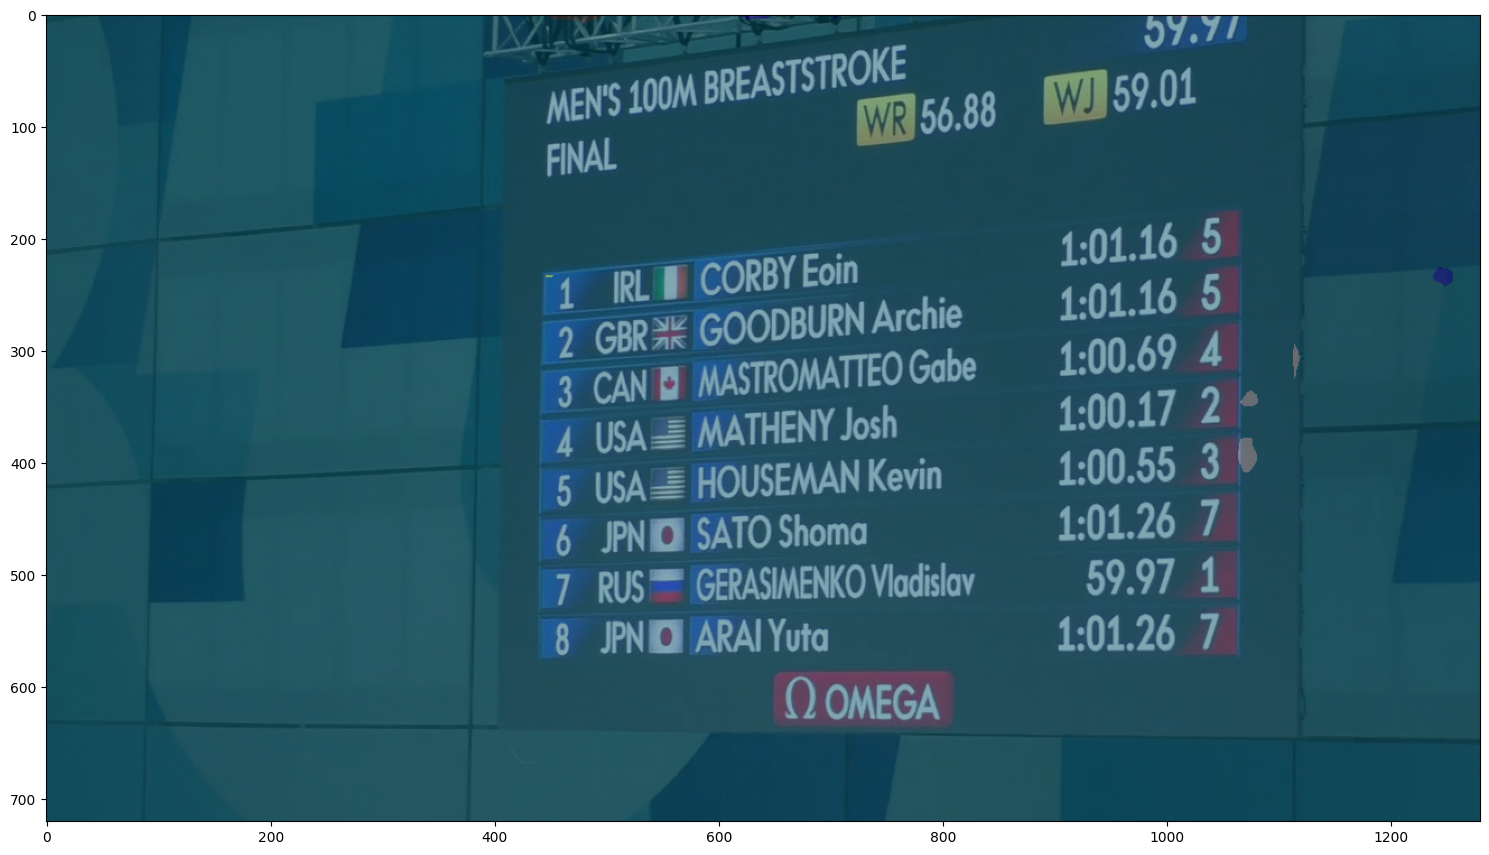

In [20]:
from mmseg.apis import init_segmentor, inference_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

config_file = '/home/said/courses/Projetinfo/sports_scr/configs/pspnet_r50-d8_512x1024_40k_cityscapes.py'
checkpoint_file = '/home/said/courses/Projetinfo/sports_scr/checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# build the model from a config file and a checkpoint file
model = init_segmentor(config_file, checkpoint_file, device='cpu')

# test a single image
img = all_image_paths[0]
result = inference_segmentor(model, img)

# show the results
show_result_pyplot(model, img, result, get_palette('cityscapes'))

In [27]:
model.CLASSES

('road',
 'sidewalk',
 'building',
 'wall',
 'fence',
 'pole',
 'traffic light',
 'traffic sign',
 'vegetation',
 'terrain',
 'sky',
 'person',
 'rider',
 'car',
 'truck',
 'bus',
 'train',
 'motorcycle',
 'bicycle')

In [25]:
set(result[0].flatten())

{2, 5, 7, 13, 16}

In [28]:
image, binary_image, mask, crop_img = get_roi_segformer(model, all_image_paths[14], crop_percent=0.01)

{43}


IndexError: tuple index out of range